# Chest X-Ray Medical Diagnosis with Deep Learning + GradCAM

This notebook demonstrates a deep learning approach for chest X-ray medical diagnosis using the **ChestX-ray8 dataset** and visualizing model predictions with **GradCAM**.

The goal of this notebook is to:
- Load and preprocess the ChestX-ray8 dataset.
- Utilize a pre-trained DenseNet121 model for diagnosis.
- Implement and apply GradCAM to interpret model predictions.

#### DISCLAIMER
This notebook is adapted from materials originally developed for a deep learning in healthcare course. The original version of this notebook can be found on GitHub: [https://github.com/LaurentVeyssier/Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning/tree/main](https://github.com/LaurentVeyssier/Chest-X-Ray-Medical-Diagnosis-with-Deep-Learning/tree/main).

The dataset used is the ChestX-ray8 dataset: [https://arxiv.org/abs/1705.02315](https://arxiv.org/abs/1705.02315).

## Approach

The notebook follows a standard deep learning pipeline:
- **Data Loading and Exploration:** Loading the ChestX-ray8 dataset and performing initial data analysis.
- **Image Preprocessing:** Standardizing images using Keras's ImageDataGenerator.
- **Addressing Class Imbalance:** Implementing a weighted loss function to handle the imbalance in disease prevalence.
- **Model Architecture:** Using a pre-trained DenseNet121 model and adding a custom classification layer.
- **Training:** Training the model with the processed data.
- **Prediction and Evaluation:** Making predictions on the test set.
- **Interpreting Models with GradCAM:** Applying GradCAM to visualize the areas of the image the model focuses on for its predictions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DO NOT EXECUTE AGAIN
# import kagglehub
# import os
# from google.colab import drive

# path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")

# print("Path to dataset files:", path)

# drive_path = '/content/drive/MyDrive/SIBGRAPI/chest_dataset'

# os.makedirs(drive_path, exist_ok=True)

# dataset_dir_name = os.path.basename(path)

# downloaded_dataset_path = os.path.join(path, dataset_dir_name)

# !mv "{path}" "{drive_path}/"

# print(f"Dataset moved to: {drive_path}/{dataset_dir_name}")

100%|██████████| 2.30G/2.30G [00:22<00:00, 111MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
Dataset moved to: /content/drive/MyDrive/SIBGRAPI/chest_dataset/3


In [ ]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

# Data Exploration
We will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315).


In [ ]:
# Defining paths and classes
from pathlib import Path
class CFG:
  DATA_PATH = Path("/content/drive/MyDrive/SIBGRAPI/chest_dataset/3")
  BASE_PATH = Path("/content/drive/MyDrive/SIBGRAPI/chest_dataset/3/images-224/images-224")
  OUTPUT_PATH = Path("/content/drive/MyDrive/SIBGRAPI/chest_dataset/")
  CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]

In [ ]:
# Creating dataframes with data to train, validation and test
import pandas as pd

data_entry_df = pd.read_csv(f'{CFG.DATA_PATH}/Data_Entry_2017.csv')
bbox_df = pd.read_csv(f'{CFG.DATA_PATH}/BBox_List_2017_Official_NIH.csv')

with open(f'{CFG.DATA_PATH}/train_val_list_NIH.txt', 'r') as f:
    train_val_list = [line.strip() for line in f]
with open(f'{CFG.DATA_PATH}/test_list_NIH.txt', 'r') as f:
    test_list = [line.strip() for line in f]

train_val_df = data_entry_df[data_entry_df['Image Index'].isin(train_val_list)].copy()
test_df = data_entry_df[data_entry_df['Image Index'].isin(test_list)].copy()

train_val_df['full_path'] = train_val_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))
test_df['full_path'] = test_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))

print(len(train_val_df))
print(len(test_df))

86524
25596


In [ ]:
# Adjusting image paths
import os
import pandas as pd
from sklearn.model_selection import train_test_split

train_val_df = data_entry_df[data_entry_df['Image Index'].isin(train_val_list)].copy()
test_df = data_entry_df[data_entry_df['Image Index'].isin(test_list)].copy()

train_val_df['full_path'] = train_val_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))
test_df['full_path'] = test_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))

for cls in CFG.CLASS_NAMES:
    train_val_df[cls] = train_val_df['Finding Labels'].str.contains(cls).astype(int)
    test_df[cls] = test_df['Finding Labels'].str.contains(cls).astype(int)

train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_df = train_df[train_df['full_path'].apply(os.path.exists)]
val_df = val_df[val_df['full_path'].apply(os.path.exists)]
test_df = test_df[test_df['full_path'].apply(os.path.exists)]

print(len(train_df))
print(len(val_df))
print(len(test_df))

os.makedirs(CFG.OUTPUT_PATH, exist_ok=True)
train_df.to_csv(f'{CFG.OUTPUT_PATH}/train.csv', index=False)
val_df.to_csv(f'{CFG.OUTPUT_PATH}/validation.csv', index=False)
test_df.to_csv(f'{CFG.OUTPUT_PATH}/test.csv', index=False)


train_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/train.csv')
val_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/validation.csv')
test_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/test.csv')

61120
6776
18019


In [ ]:
print(f"Train set: The total patient ids are {train_df['Patient ID'].count()}, from those the unique ids are {train_df['Patient ID'].value_counts().shape[0]} ")
print(f"Test set: The total patient ids are {test_df['Patient ID'].count()}")

Train set: The total patient ids are 61120, from those the unique ids are 19134 
Test set: The total patient ids are 18019


### Explore data labels
Create a list of the names of each patient condition or disease.

In [ ]:
# Get all columns from the dataframe
all_columns = train_df.columns.tolist()

# Filter out columns that are not in CFG.CLASS_NAMES
columns = [col for col in all_columns if col in CFG.CLASS_NAMES]

print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
The class Atelectasis has 5824 samples
The class Cardiomegaly has 1162 samples
The class Effusion has 6082 samples
The class Infiltration has 8946 samples
The class Mass has 2886 samples
The class Nodule has 3321 samples
The class Pneumonia has 610 samples
The class Pneumothorax has 1787 samples
The class Consolidation has 2031 samples
The class Edema has 1022 samples
The class Emphysema has 1019 samples
The class Fibrosis has 978 samples
The class Pleural_Thickening has 1520 samples
The class Hernia has 101 samples


### Data Visualization


Display Random Images


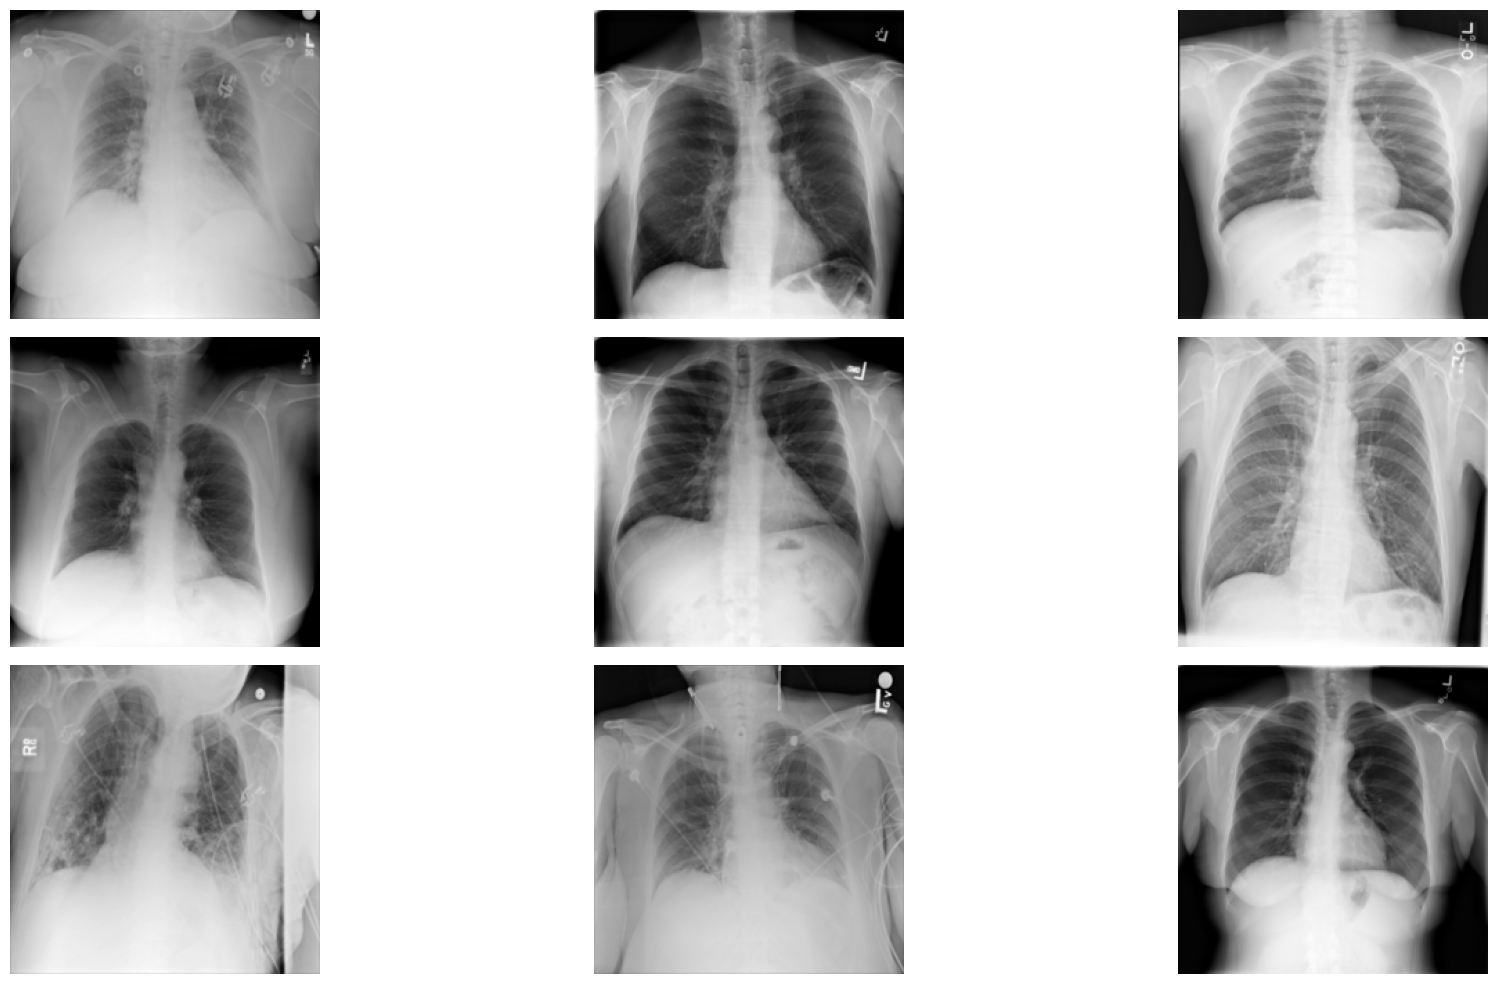

In [ ]:
images = train_df['full_path'].values

random_images = [np.random.choice(images) for i in range(9)]

print('Display Random Images')

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### Investigate a single image


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel
The maximum pixel value is 0.8235 and the minimum is 0.0196
The mean value of the pixels is 0.5321 and the standard deviation is 0.1579


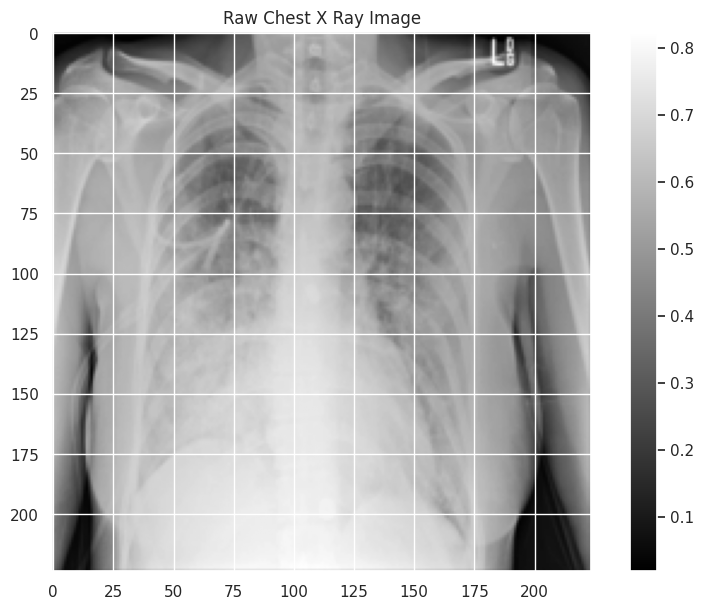

In [ ]:
sample_img = train_df["full_path"][0]
raw_image = plt.imread(os.path.join(sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plot up the distribution of pixel values in the image shown above.

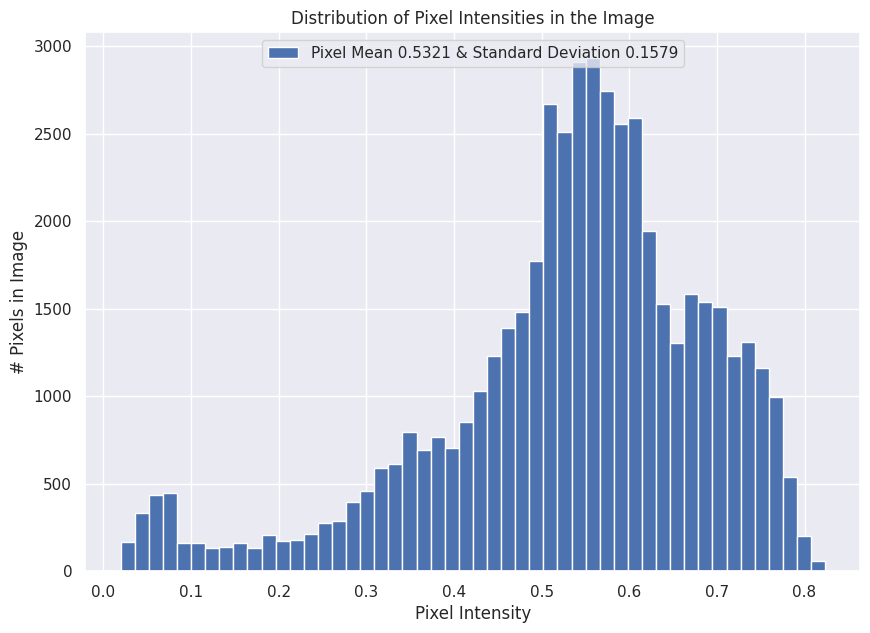

In [ ]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

# Image Preprocessing in Keras
### Standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Create an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels.

In [ ]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    print("getting train generator...")
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """

    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = get_train_generator(train_df, '', "full_path", labels)

    batch = raw_train_generator.__next__()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)

    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
labels = CFG.CLASS_NAMES
train_generator = get_train_generator(train_df, '', "full_path", labels)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, '', "full_path", labels)

getting train generator...
Found 61120 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
getting train generator...
Found 61120 validated image filenames.

getting valid generator...
Found 6776 validated image filenames.

getting test generator...
Found 18019 validated image filenames.


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.7152 and the minimum is -2.4635
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


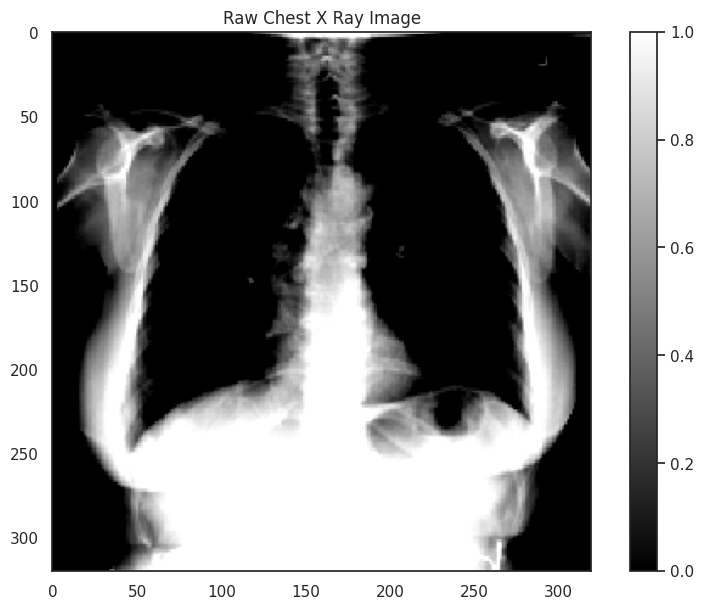

In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [ ]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(224, 224)


/tmp/ipython-input-2816129532.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
/tmp/ipython-input-2816129532.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


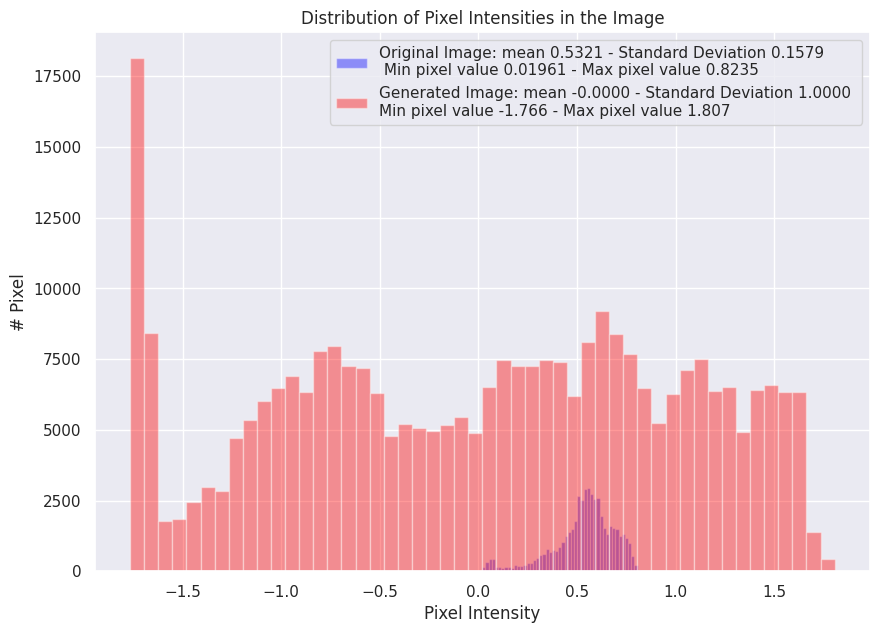

In [ ]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(),
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue',
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}',
             color='red',
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

### Addressing Class Imbalance - Weighted Loss
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

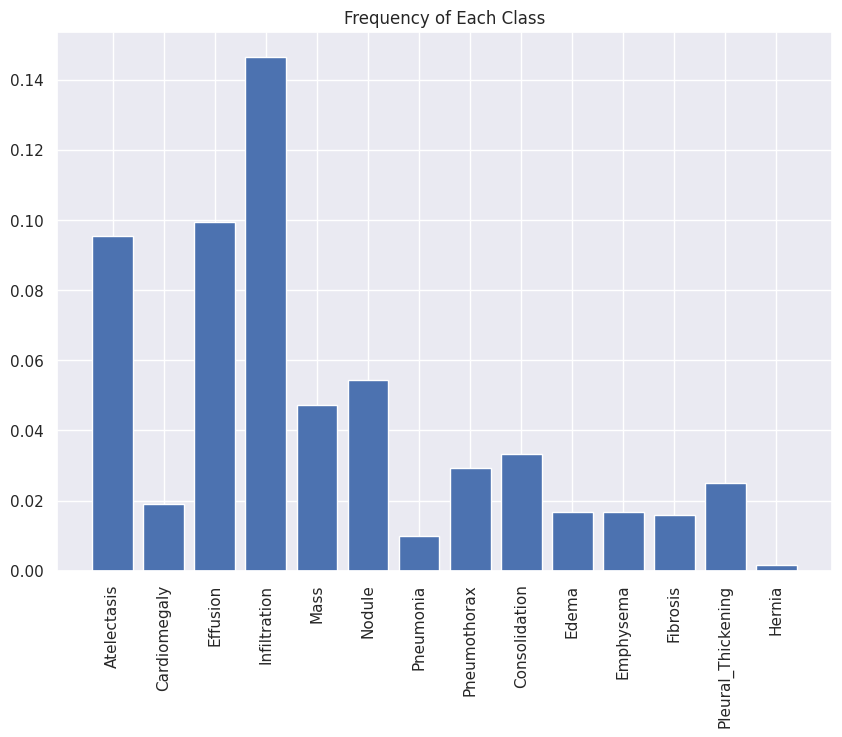

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive.

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero).

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequencies

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.09528796, 0.01901178, 0.09950916, 0.1463678 , 0.04721859,
       0.05433573, 0.00998037, 0.02923757, 0.03322971, 0.0167212 ,
       0.01667212, 0.01600131, 0.02486911, 0.00165249])

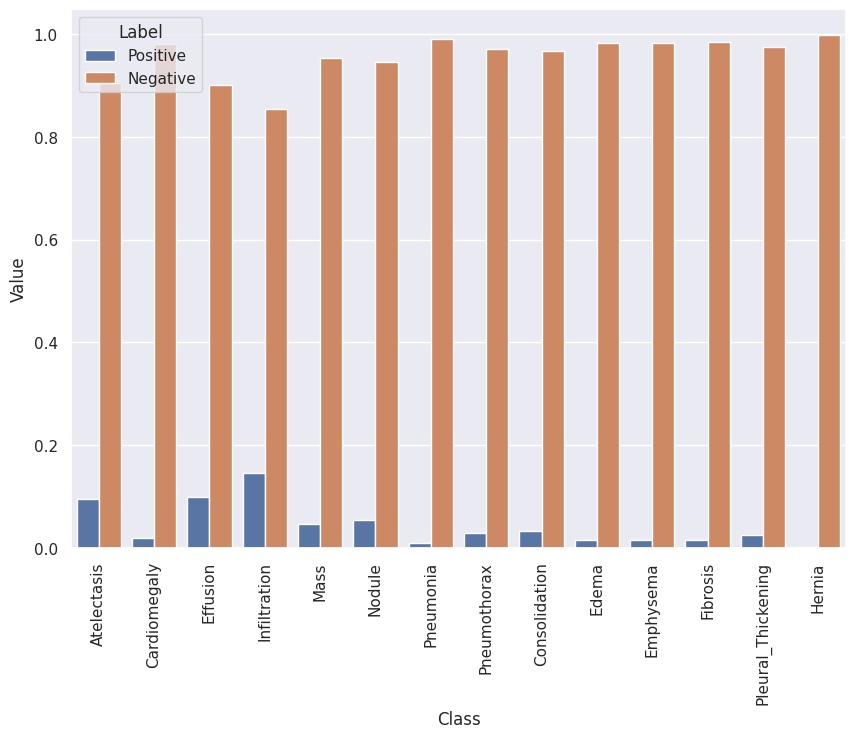

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

The contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.

To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other :

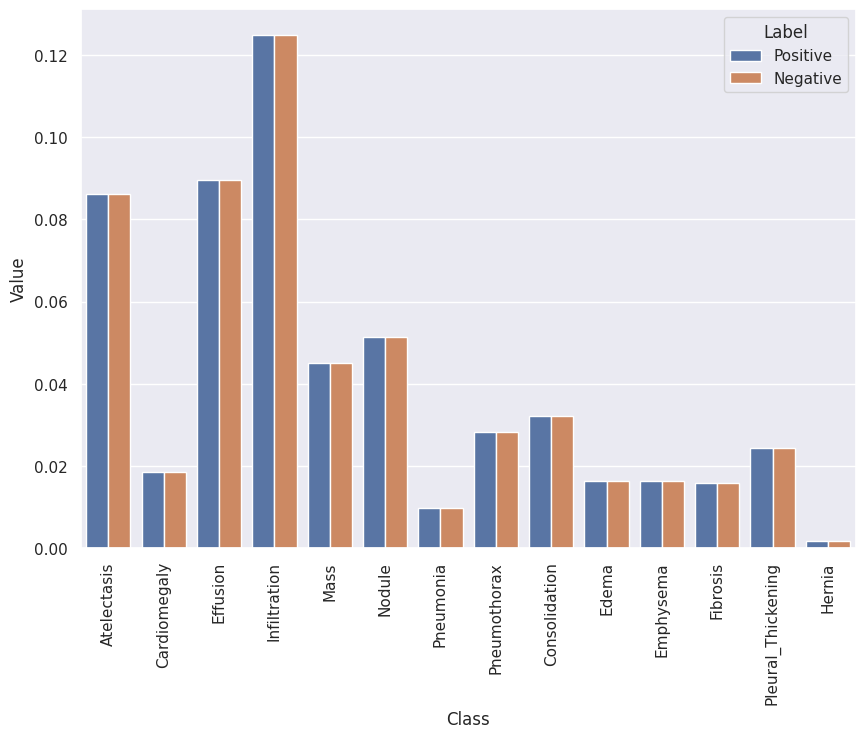

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)])], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

After computing the weights, our final weighted loss for each training case will be

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss

In [ ]:
import tensorflow as tf

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += - pos_weights[i] * tf.reduce_mean(y_true[:,i] * tf.math.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * tf.reduce_mean((1-y_true[:,i]) * tf.math.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss

    return weighted_loss

### DenseNet121
Use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model. Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.
- For a detailed explanation of Densenet, check [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

In [ ]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():

    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights=f"{CFG.DATA_PATH}/densenet.hdf5", include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights(f"{CFG.DATA_PATH}/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [ ]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


let's see the layers that our model is composed of.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

total number of layers = 429


In [ ]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers
                if str(type(layer)).find('Conv2D') > -1]

## Training

In [ ]:
# Here, we're using a pretrained model, but you can train your own by doing:
history = model.fit(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=100,
                              validation_steps=25,
                              epochs = 1)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

## Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the predict_generator function to generate the predictions for the images in our test set.

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator)//100)
predicted_vals.shape  # number of test samples x number of classes to predict

22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step


(176, 14)

## Interpreting Deep Learning Models

Let's load in an X-ray image.

/content/drive/MyDrive/SIBGRAPI/chest_dataset/3/images-224/images-224/00018284_020.png
Label  [0 0 0 0 0 1 0 0 0 0 0 0 0 0]


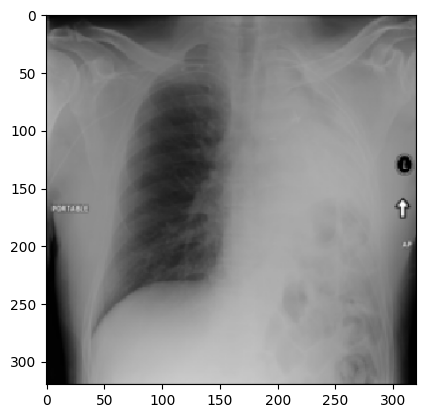

In [ ]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["full_path"].values):
        path = img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x = image.img_to_array(x) # Convert PIL image to numpy array
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        # Note: Mean and std are calculated on the training set and passed as arguments
        mean, std = get_mean_std_per_batch(train_df, H=H, W=W) # Assuming train_df is accessible here for mean/std calculation
        x = image.img_to_array(x) # Convert PIL image to numpy array
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = '/content/drive/MyDrive/SIBGRAPI/chest_dataset/3/images-224/images-224/00018284_020.png'
print(im_path)
pred_label = test_df[test_df["full_path"] == im_path][labels].values[0]
print("Label ", pred_label)
x = load_image(im_path, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

Next, let's get our predictions. Before we plug the image into our model, we have to normalize it. Run the next cell to compute the mean and standard deviation of the images in our training set.

In [ ]:
mean, std = get_mean_std_per_batch(train_df)

Now we are ready to normalize and run the image through our model to get predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


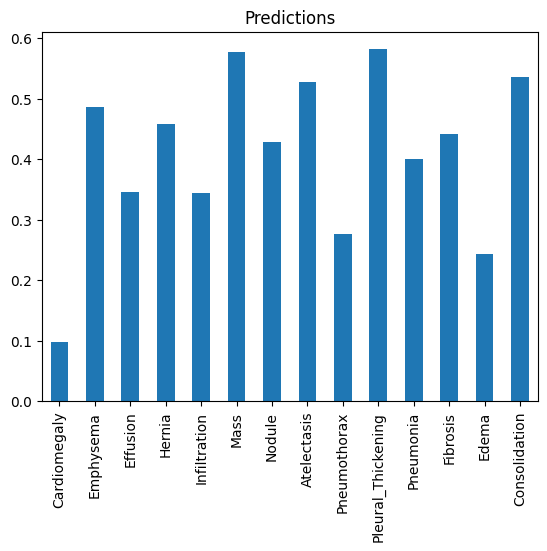

In [ ]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [ ]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.097873,0.487022,0.346367,0.45843,0.343618,0.5776,0.429196,0.527768,0.27642,0.581709,0.401093,0.441656,0.24423,0.536882


# GradCAM

GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, we can generate a heatmap by computing gradients of the specific class scores we are interested in visualizing.

#### Getting Intermediate Layers

Perhaps the most complicated part of computing GradCAM is accessing intermediate activations in our deep learning model and computing gradients with respect to the class output. Typically we'll only be extracting one of the last few. The last few layers usually have more abstract information. To access a layer, we can use `model.get_layer(layer).output`, which takes in the name of the layer in question. Here we are going to extract the raw output of the last convolutional layer `conv5_block16_concat`.

In [ ]:
spatial_maps =  model.get_layer('conv5_block16_concat').output


In [ ]:
# Create a Keras Model that outputs the spatial maps
get_spatial_maps_model = Model(inputs=model.input, outputs=spatial_maps)
print(get_spatial_maps_model)

<Functional name=functional_10, built=True>


We see that we now have a `Functional` object. Now, to get the actual intermediate output evaluated with a particular input, we just plug in an image to this function:

In [ ]:
# get an image
x = load_image_normalize(im_path, mean, std)
print(f"x is of type {type(x)}")
print(f"x is of shape {x.shape}")

x is of type <class 'numpy.ndarray'>
x is of shape (1, 320, 320, 3)


In [ ]:
# get the 0th item in the list
spatial_maps_x = get_spatial_maps_model([x])[0]
print(f"spatial_maps_x is of type {type(spatial_maps_x)}")
print(f"spatial_maps_x is of shape {spatial_maps_x.shape}")
print(f"spatial_maps_x without the batch dimension has shape {spatial_maps_x[0].shape}")

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 320, 320, 3))']
  warnings.warn(msg)


spatial_maps_x is of type <class 'tensorflow.python.framework.ops.EagerTensor'>
spatial_maps_x is of shape (10, 10, 1024)
spatial_maps_x without the batch dimension has shape (10, 1024)


#### Getting Gradients

The other major step in computing GradCAMs is getting gradients with respect to the output for a particular class.

In [ ]:
# get the output of the model
output_with_batch_dim = model.output
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

excluding the batch dimension, the output for all 14 categories of disease has shape (14,)


The output has 14 categories, one for each disease category, indexed from 0 to 13. Cardiomegaly is the disease category at index 0.

In [ ]:
import tensorflow as tf

def get_gradient_function(model, layer_name, category_index):
    """
    Create a function that computes the gradient of the output for a given category
    with respect to the spatial map of a specified layer.

    Args:
        model (Keras.model): model to compute the gradient for.
        layer_name (str): name of the layer to compute gradients with respect to.
        category_index (int): index of the output category to compute gradients for.

    Returns:
        compute_gradient (function): A function that takes an input image (tensor)
                                     and returns the gradient of the specified category output
                                     with respect to the spatial map of the layer.
    """
    # Create a temporary model that outputs both the final prediction and the intermediate layer
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.output, model.get_layer(layer_name).output]
    )

    def compute_gradient(image):
        with tf.GradientTape() as tape:
            # Get the output of the model and the spatial map for the input image
            model_output, spatial_map = grad_model(image)
            # Get the output for the specific category
            output_for_category = model_output[:, category_index]

        # Compute the gradient of the category output with respect to the spatial map
        gradient = tape.gradient(output_for_category, spatial_map)
        return gradient, spatial_map

    return compute_gradient

In [ ]:
# Create the function that gets the gradient and spatial map
compute_gradient_and_spatial_map = get_gradient_function(model, 'conv5_block16_concat', 0)

# get an input x-ray image
x = load_image_normalize(im_path, mean, std)
print(f"X-ray image has shape {x.shape}")

# use the compute_gradient_and_spatial_map function to get the gradient and spatial map
grad_x_with_batch_dim, spatial_map_all_dims = compute_gradient_and_spatial_map(x)

print(f"grad_x_with_batch_dim is type {type(grad_x_with_batch_dim)} and shape {grad_x_with_batch_dim.shape}")
print(f"spatial_map_all_dims is type {type(spatial_map_all_dims)} and shape {spatial_map_all_dims.shape}")

# To remove the batch dimension, take the value at index 0 of the batch dimension
grad_x = grad_x_with_batch_dim[0]
spatial_map_val = spatial_map_all_dims[0]

print(f"grad_x is type {type(grad_x)} and shape {grad_x.shape}")
print(f"spatial_map_val is type {type(spatial_map_val)} and shape {spatial_map_val.shape}")

X-ray image has shape (1, 320, 320, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


grad_x_with_batch_dim is type <class 'tensorflow.python.framework.ops.EagerTensor'> and shape (1, 10, 10, 1024)
spatial_map_all_dims is type <class 'tensorflow.python.framework.ops.EagerTensor'> and shape (1, 10, 10, 1024)
grad_x is type <class 'tensorflow.python.framework.ops.EagerTensor'> and shape (10, 10, 1024)
spatial_map_val is type <class 'tensorflow.python.framework.ops.EagerTensor'> and shape (10, 10, 1024)


In [ ]:
# get an input x-ray image
x = load_image_normalize(im_path, mean, std)
print(f"X-ray image has shape {x.shape}")

X-ray image has shape (1, 320, 320, 3)


### Implementing GradCAM

In [ ]:
def grad_cam(input_model, image, category_index, layer_name):
    """
    GradCAM method for visualizing input saliency.

    Args:
        input_model (Keras.model): model to compute cam for
        image (tensor): input to model, shape (1, H, W, 3)
        cls (int): class to compute cam with respect to
        layer_name (str): relevant layer in model
        H (int): input height
        W (int): input width
    Return:
        cam ()
    """
    cam = None

    # 1. Get gradients of last layer with respect to output and spatial map
    compute_gradient_and_spatial_map = get_gradient_function(input_model, layer_name, category_index)
    grads_val, spatial_map_val = compute_gradient_and_spatial_map(image)


    # Reshape activations and gradient to remove the batch dimension
    # Shape goes from (B, H, W, C) to (H, W, C)
    # B: Batch. H: Height. W: Width. C: Channel
    # Reshape spatial map output to remove the batch dimension
    spatial_map_val = spatial_map_val[0]

    # Reshape gradients to remove the batch dimension
    grads_val = grads_val[0]

    # 4. Compute weights using global average pooling on gradient
    # grads_val has shape (Height, Width, Channels) (H,W,C)
    # Take the mean across the height and also width, for each channel
    # Make sure weights have shape (C)
    weights = np.mean(grads_val, axis=(0,1))

    # 5. Compute dot product of spatial map values with the weights
    cam = np.dot(spatial_map_val, weights)    # shape (10,10,1024) x shape(1024,) resulting into shape(10,10)

    H, W = image.shape[1], image.shape[2]
    cam = np.maximum(cam, 0) # ReLU so we only get positive importance
    cam = cv2.resize(cam, (W, H), cv2.INTER_NEAREST)
    cam = cam / cam.max()

    return cam

- Generate the CAM for the image

In [ ]:
im = load_image_normalize(im_path, mean, std)
predicted_class = pred_label.argmax()
print(f"Predicted class: {predicted_class}")
cam = grad_cam(model, im, predicted_class, 'conv5_block16_concat')

Predicted class: 5


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


- Visualize the CAM and the original image.

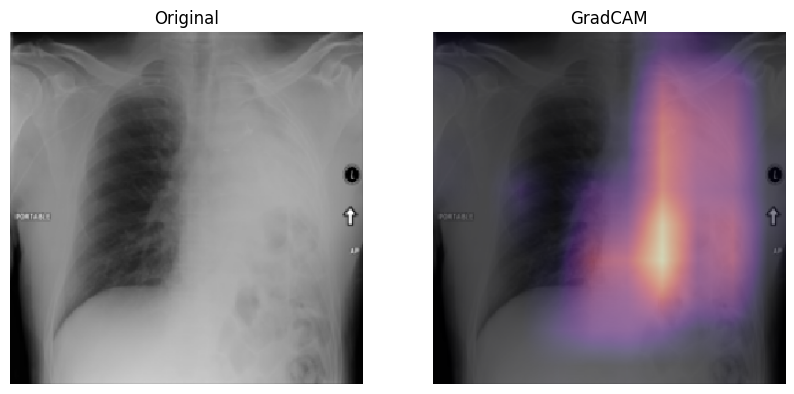

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.subplot(121)
plt.imshow(load_image(im_path, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(122)
plt.imshow(load_image(im_path, preprocess=False), cmap='gray')
plt.imshow(cam, cmap='magma', alpha=0.5)
plt.title("GradCAM")
plt.axis('off')
plt.show()

We can see that it focuses on the large (white) area on the lung. Indeed this is a clear case of Mass.


### Using GradCAM to Visualize Multiple Labels

We can use GradCAMs for multiple labels on the same image. Let's do it for Cardiomegaly, Mass, and Edema.

In [ ]:
def compute_gradcam(model, img, mean, std, data_dir, df,
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image.
    This method will use the `grad_cam` function.

    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name we want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels we want to compute the GradCAM for.
        layer_name: Intermediate layer from the model we want to compute the GradCAM for.
    """
    img_path = data_dir / img
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)

    # Use 'Image Index' and data_dir to find the row in the dataframe
    img_row = df[df["Image Index"] == img]
    if not img_row.empty:
        print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(img_row[labels].values[0]))[0]))
    else:
        print(f"Image {img} not found in the dataframe.")


    plt.figure(figsize=(20, 15))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, preprocess=False), cmap='gray')

    j = 1

    # Loop through all labels
    for i in range(len(labels)):

        # Check if the label is one of the selected labels
        if labels[i] in selected_labels:

            gradcam = grad_cam(model, preprocessed_input, i, layer_name)

            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1
    plt.show()

Run the following cells to print the ground truth diagnosis for a given case and show the original x-ray as well as GradCAMs for Cardiomegaly, Mass, and Edema.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Ground Truth:  Mass


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


Generating gradcam for class Cardiomegaly (p=0.10)
Generating gradcam for class Mass (p=0.58)
Generating gradcam for class Edema (p=0.24)


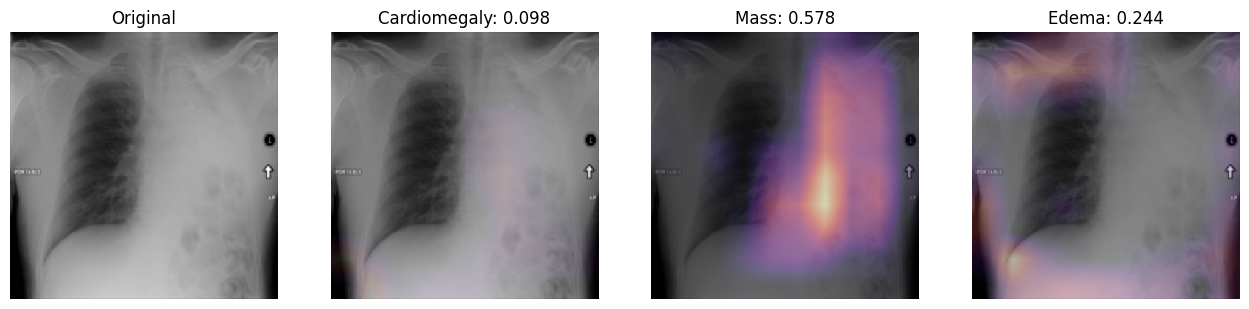

In [ ]:
image_filename = '00018284_020.png'
labels_to_show = ['Cardiomegaly', 'Mass', 'Edema']
compute_gradcam(model, image_filename, mean, std, CFG.BASE_PATH, test_df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Ground Truth:  Mass


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


Generating gradcam for class Cardiomegaly (p=0.01)
Generating gradcam for class Mass (p=0.93)
Generating gradcam for class Edema (p=0.07)


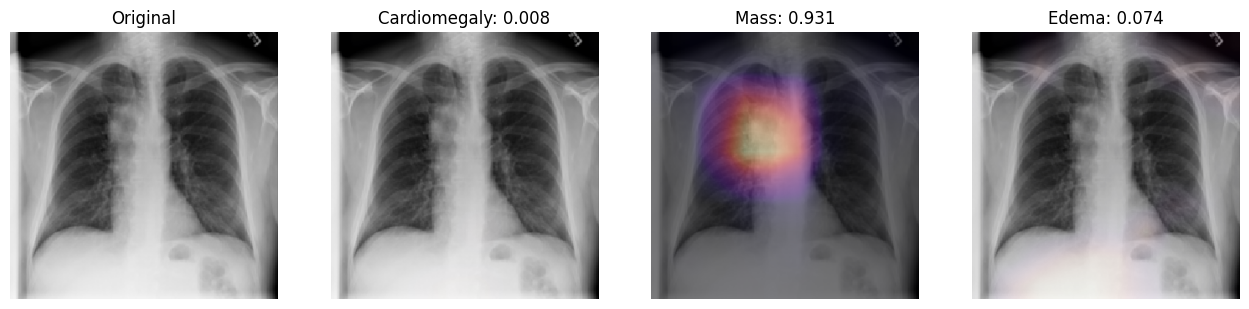

In [ ]:
image_filename = '00005410_000.png'
compute_gradcam(model, image_filename, mean, std, CFG.BASE_PATH, train_df, labels, labels_to_show)

In the example above, the model correctly focuses on the mass near the center of the chest cavity.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Ground Truth:  Edema


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


Generating gradcam for class Cardiomegaly (p=0.25)
Generating gradcam for class Mass (p=0.29)
Generating gradcam for class Edema (p=0.78)


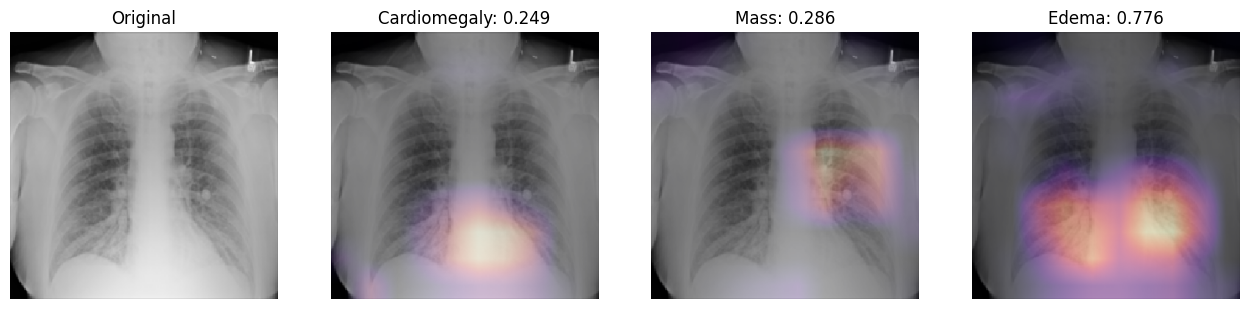

In [ ]:
image_name = '00004090_002.png'
compute_gradcam(model, image_name, mean, std, CFG.BASE_PATH, train_df, labels, labels_to_show)

Here the model correctly picks up the signs of edema near the bottom of the chest cavity. This visualization might be helpful for error analysis; for example, we can notice that the model is indeed looking at the expected area to make the prediction.